In [1]:
import sys
sys.path.append('../../')

# Dataset Seed
from datetime import date, datetime
r_today = date.today().strftime("%y%m%d")
r_time = datetime.now().strftime("%H%M")
# dataset_seed = int(f'{r_today}{r_time}')
dataset_seed = 'dataset_q1_v1'

from keras.callbacks import EarlyStopping

from src.hypermodels import *
from src.utils  import *
from src.dataset import *

question_id = 1

# Load the data

In [7]:
# duel_results_path = f'../../data/duel_results/duels_question_{question_id}'
# image_file_dir = '../../data/Mapillary_data/Sample_web_green'
# 
# print(f'Dataset Seed:{dataset_seed}') # For reproducibility, seed is defined using the date and time (e.g. 2021-01-01 12:30:15 -> seed = 20210101123015)
image_size = 224
# (x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_dataset(duel_results_path, 
#                                                                        image_file_dir, 
#                                                                        img_size=image_size,
#                                                                        model_type='ranking',
#                                                                        shuffle=True, 
#                                                                        shuffle_seed=dataset_seed)

# Load from the saved numpy arrays
x1_train,x2_train = np.load('../../data/datasets_v1/x_train.npy')
y_train = np.load('../../data/datasets_v1/y_train.npy')

x1_val,x2_val = np.load('../../data/datasets_v1/x_validation.npy')
y_val = np.load('../../data/datasets_v1/y_validation.npy')

x1_test,x2_test = np.load('../../data/datasets_v1/x_test.npy')
y_test = np.load('../../data/datasets_v1/y_test.npy')

x_train = [x1_train,x2_train]
x_val = [x1_val,x2_val]
del x1_train,x2_train,x1_val,x2_val

# Data Preprocessing Hyperparameters (Using Keras Preprocessing Layers)

In [3]:
hps_data_preprocessing = {
    'image_preprocessing': {
        'resize': {'height': image_size, 'width': image_size, 'interpolation': 'bicubic'},
        'rescale': {'scale': 1.0 / 255},
    },
    'image_augmentation': {
        'random_rotation': {'factor': 0.4},
        'random_flip': {'mode': 'horizontal_and_vertical'},
        'random_contrast': {'factor': 0.7},
        'random_brightness': {'factor': 0.4, 'value_range': [0.0, 1.0]},
        'random_zoom': {'height_factor': 0.2, 'width_factor': 0.2},
    },
}

image_preprocessing_layers = Sequential(
    [
        layers.Resizing(height=hps_data_preprocessing['image_preprocessing']['resize']['height'],
                     width=hps_data_preprocessing['image_preprocessing']['resize']['width'], 
                     interpolation=hps_data_preprocessing['image_preprocessing']['resize']['interpolation']
                     ),
        layers.Rescaling(scale=hps_data_preprocessing['image_preprocessing']['rescale']['scale'])
    ],
    name='image_preprocessing'
)

image_augmentation_layers = Sequential(
    [
        layers.RandomRotation(factor=hps_data_preprocessing['image_augmentation']['random_rotation']['factor']),
        layers.RandomFlip(mode=hps_data_preprocessing['image_augmentation']['random_flip']['mode']),
        layers.RandomContrast(factor=hps_data_preprocessing['image_augmentation']['random_contrast']['factor']),
        layers.RandomBrightness(factor=hps_data_preprocessing['image_augmentation']['random_brightness']['factor'],
                                value_range=hps_data_preprocessing['image_augmentation']['random_brightness']['value_range']),
        layers.RandomZoom(height_factor=hps_data_preprocessing['image_augmentation']['random_zoom']['height_factor'],
                          width_factor=hps_data_preprocessing['image_augmentation']['random_zoom']['width_factor'])
    ],
    name='image_augmentation'
)

# Model Training Hyperparameters

In [4]:
hps_model_training = {'optimizer': 'adam',
                      'learning_rate': 0.0001,
                      'loss': 'binary_crossentropy',
                      'metrics': ['accuracy'],
                      'batch_size': 64,
                      'epochs': 30,
                      }

# Model Architecture Hyperparameters

In [5]:
hp_model_architecture = {
    'feature_extractor': 'vgg19',
    'num_dense_layers': 2,
    'dense_units': [64,80],
    'dense_dropout_rates': [0.5, 0.5],
    'dense_activation': ['relu', 'relu'],
    'ranking_score_activation': 'linear',
    'final_activation': 'sigmoid',
}

# Train the model

In [8]:
meta_model = create_siamese_network(img_size=image_size,
                                    image_preprocessing_layers=image_preprocessing_layers,
                                    image_augmentation_layers=image_augmentation_layers,
                                    feature_extractor=hp_model_architecture['feature_extractor'],
                                    num_dense_layers=hp_model_architecture['num_dense_layers'], 
                                    dense_units_list=hp_model_architecture['dense_units'],
                                    dense_activation_list=hp_model_architecture['dense_activation'],
                                    dropout_rate_list=hp_model_architecture['dense_dropout_rates'],
                                    ranking_score_activation=hp_model_architecture['ranking_score_activation'],
                                    final_activation=hp_model_architecture['final_activation'],
                                    unfreeze_layers = 4, # Unfreeze the last 4 layers of the feature extractor
                                    pretrained_weights='imagenet', # Use the weights pretrained on ImageNet for the feature extractor
                                    )

meta_model.compile(optimizer=hps_model_training['optimizer'],
                   loss=hps_model_training['loss'],
                   metrics=hps_model_training['metrics'])

history = meta_model.fit(
    x=x_train,
    y=y_train,
    batch_size=hps_model_training['batch_size'],
    epochs=hps_model_training['epochs'],
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_accuracy',
                             patience=5,
                             verbose=1,
                             restore_best_weights=True)],
    verbose=1,
)


Epoch 1/30
43/43 [==============================] - 28s 230ms/step - loss: 0.7231 - accuracy: 0.7249 - val_loss: 0.8861 - val_accuracy: 0.8105
Epoch 2/30
43/43 [==============================] - 7s 174ms/step - loss: 0.6017 - accuracy: 0.7746 - val_loss: 0.4561 - val_accuracy: 0.7963
Epoch 3/30
43/43 [==============================] - 7s 175ms/step - loss: 0.5532 - accuracy: 0.7673 - val_loss: 0.4940 - val_accuracy: 0.8160
Epoch 4/30
43/43 [==============================] - 7s 175ms/step - loss: 0.4998 - accuracy: 0.7947 - val_loss: 0.3808 - val_accuracy: 0.8346
Epoch 5/30
43/43 [==============================] - 7s 175ms/step - loss: 0.4676 - accuracy: 0.8060 - val_loss: 0.3657 - val_accuracy: 0.8324
Epoch 6/30
43/43 [==============================] - 7s 174ms/step - loss: 0.4406 - accuracy: 0.8173 - val_loss: 0.3640 - val_accuracy: 0.8269
Epoch 7/30
43/43 [==============================] - 7s 174ms/step - loss: 0.4046 - accuracy: 0.8228 - val_loss: 0.3632 - val_accuracy: 0.8248
Epoch

# Save the model and the training results

Hyperparams saved!
Model history saved to csv!
Model architecture saved!
Model weights saved!
Model saved to keras!
Figure Training and ValidationLoss saved!


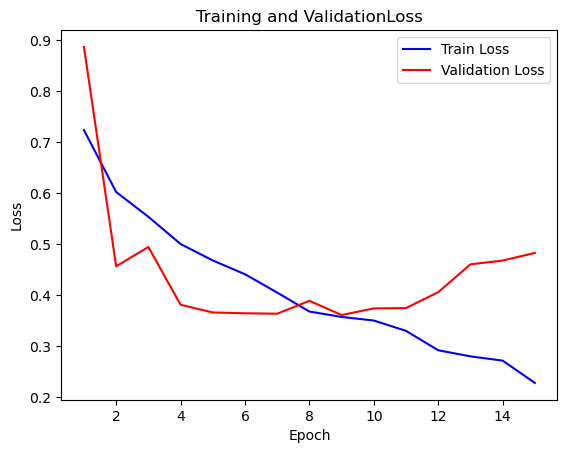

Figure Training and ValidationAccuracy saved!


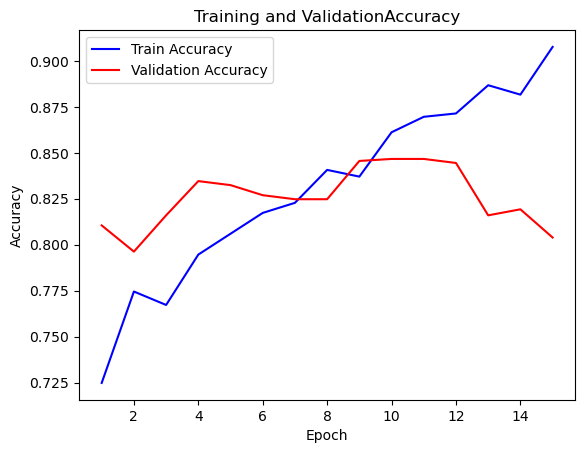

In [10]:
# Save the training results of meta_model
from src.utils import safe_save_training_results

best_val_acc = max(history.history['val_accuracy'])
model_save_dir = 'baseline_models/Ranking_VGG19_BestValAcc{:.4f}_{}'.format(best_val_acc,dataset_seed)

safe_save_training_results(hyperparams_dict={'model_architecture': hp_model_architecture,
                                             'model_training': hps_model_training,
                                             'data_preprocessing': hps_data_preprocessing},
                           model=meta_model,
                           model_save_type='keras', 
                           history=history, 
                           his_save_type='csv', 
                           save_dir = model_save_dir,)

# Save the plot
plot_model_metrics(history, ['loss', 'accuracy'], save_dir=model_save_dir)